In [1]:
import numpy as np
import math
import random 
import matplotlib.pyplot as plt
import random
import copy    # array-copying convenience
import sys     # max float
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing

In [2]:
def cal_SD(sm):
    sd = 0
    for i in range(len(sm)):
        sd += sm[i]**2
    sd /= len(sm)
    sd = math.sqrt(sd)
    return sd

In [3]:
def fit(final_d , sd):
    return final_d**sd

In [4]:
def new_position(path, position):
    new_position = []
    for i in range(len(position)):
        new_position.append(position[path[i]])
    return new_position

In [5]:
def print_path(new_position , color = 'g--'):    
    t = [new_position[0]]
    for i in range(1,len(new_position)):
        t = np.append(t, [new_position[i]], axis=0)
    plt.plot(t[:,0],t[:,1],'bo')
    plt.plot(t[0,0],t[0,1],'ro')
    plt.plot(t[:,0],t[:,1], color)

In [6]:
def rand_path(path ,nc):
    tmp = path[1:len(path)-1]
    random.shuffle(tmp)
        
    for i in range(1, len(path)-1):
        path[i] = tmp[i-1]
    return path

In [7]:
def print_point(path_point):
    for i in range(len(path_point)):
        print(path_point[i])   

In [8]:
def dist(x, y):
    d = (x[0] - y[0])**2 + (x[1] - y[1])**2
    return math.sqrt(d)

In [9]:
def multi_bee(nc, cp, nb, nv, max_epochs,file_num):
    m = 0
    best_multiBeePath = []
    best_total_distance = []
    fitness = float('inf')
    raw = {'total distance':[],'SD':[],'fitness':[],'best_round':[],'best_fitness':[]}
    for m in tqdm(range(max_epochs)):
#     for m in range(max_epochs):
#     while m < max_epochs:
        total_distance = []
        multiBee_path = []
        final_d = 0
        sm_dist = []
        final_d = 0
        for i in range(nv):
            multiBee_path.append([0])
        
        if m == 0:
            tmp =  [j for j in range(1,nc)]
            for i in range(nc-1):
                index = np.random.randint(len(tmp))
                row = np.random.randint(nv)
                multiBee_path[row].append(tmp[index])
                tmp.remove(tmp[index])
        else :
            for i in range(len(best_multiBeePath)):
                for j in range(1,len(best_multiBeePath[i])):
                    if np.random.randint(10) < 7:
                        multiBee_path[i].append(best_multiBeePath[i][j])
                    else:
                        row = np.random.randint(nv)
                        multiBee_path[row].append(best_multiBeePath[i][j])
        
        for i in range(nv):
            small_cp = []
            for j in range(len(multiBee_path[i])):
                    small_cp.append(cp[multiBee_path[i][j]])
            small_cp.append(cp[0])
            if(len(multiBee_path[i]) > 2):
                random.seed(1)
                total_distance.append(solve(len(small_cp), small_cp, nb, max_epochs*0.1))
            
        sumd = 0
        for i in range(len(total_distance[0])-1):
            sumd += dist(total_distance[0][i],total_distance[0][i+1])
        sm_dist.append(sumd)
        final_d += sumd
        
        if(len(total_distance) >= 2):
            sumd = 0
            for i in range(len(total_distance[1])-1):
                sumd += dist(total_distance[1][i],total_distance[1][i+1])
            sm_dist.append(sumd)
            final_d += sumd
            
        if(len(total_distance) == 3):
            sumd = 0
            for i in range(len(total_distance[2])-1):
                sumd += dist(total_distance[2][i],total_distance[2][i+1])
            sm_dist.append(sumd)
            final_d += sumd
        
        dummy = fit(final_d, cal_SD(sm_dist))
        if fitness > dummy:
            fitness = dummy
            best_multiBeePath = multiBee_path.copy()
            best_total_distance = total_distance.copy()
            best_round = m
#             print(str(m) +" :fit: "+str(fitness))
#             print("D :"+str(final_d)+"\n")
#             print("SD :"+str(cal_SD(sm_dist))+"\n")
        
#         raw['total distance'].append(final_d)
#         raw['SD'].append(cal_SD(sm_dist))
#         raw['fitness'].append(dummy)
        
        
#         m+=1
#         break
   
#     df = pd.DataFrame(raw , columns = ['Total distance', 'SD', 'fitness'])
#     df.to_csv("bee_result_"+str(file_num)+".csv")
    
    return best_round, fitness, best_total_distance, best_multiBeePath
#     return best_round, fitness, best_total_distance, best_multiBeePath ,df
        

In [10]:
def error(path,cities_position):
    d = 0.0  # total distance between cities)
    for i in range(len(path)-1):
        d += dist(cities_position[path[i]],cities_position[path[i+1]])
    return d 

In [11]:
class Bee:
    def __init__(self, nc, cp, seed):
        #self.rnd = random.Random(seed)
        self.status = 0  # 0 = inactive, 1 = active, 2 = scout
        self.path = [0 for i in range(nc)]  # potential solution
        
        for i in range(nc):
            self.path[i] = i  # [0,1,2, ...]
        
        self.path = rand_path(self.path, nc)
                
        #print("sp"+str(self.path))
        random.shuffle(self.path[1:len(self.path)-1])
        #print(str(seed) + " " + str(self.path))
        self.error = error(self.path, cp) # bee's current error
        #print("serr"+str(self.error))

In [12]:
def solve(nc, cp, nb, max_epochs):
    # solve TSP for nc cities using nb bees
    # optimal soln is [0,1,2, . . n-1]
    # create nb random bees
    
    hive = [Bee(nc, cp, i) for i in range(nb)] 

    best_err = sys.float_info.max  # dummy init value
    for i in range(nb):  # check each random bee
        if hive[i].error < best_err:
            best_err = hive[i].error
            best_path = copy.copy(hive[i].path)

    # assign initial statuses
    numActive = int(nb * 0.50)
    numScout = int(nb * 0.25)
    numInactive = nb - (numActive + numScout)
    for i in range(nb):
        if i < numInactive:
            hive[i].status = 0
        elif i < numInactive + numScout:
            hive[i].status = 2
        else:
            hive[i].status = 1
            
    epoch = 0
    while epoch < max_epochs:
        if best_err == 0.0: break
        for i in range(nb):  # process each bee
            if hive[i].status == 1:    # active bee
                # find a neighbor path and associated error
                neighbor_path = copy.copy(hive[i].path)
                ri = random.randint(1, nc-2)  # random index
                ai = 1  # adjacent index. assume last->first
                if ri < nc-2: ai = ri + 1
                tmp = neighbor_path[ri]
                neighbor_path[ri] = neighbor_path[ai]
                neighbor_path[ai] = tmp
                neighbor_err = error(neighbor_path, cp)
                
                # check if neighbor path is better
                p = random.random()  # [0.0 to 1.0)
                if (neighbor_err < hive[i].error or (neighbor_err >= hive[i].error and p < 0.05)):
                    hive[i].path = neighbor_path
                    hive[i].error = neighbor_err
                    #print("abee"+str(hive[i].path))

                # new best?
                if hive[i].error < best_err:
                    best_err = hive[i].error
                    best_path = hive[i].path
                    #print("epoch = " + str(epoch) + " new best path found ", end="")
                    #print("with error = " + str(best_err))
            
            # active bee code
            elif hive[i].status == 2:  # scout bee
                # make random path and error
                random_path = [0 for i in range(nc)]
                for i in range(nc):
                    random_path[i] = i  # [0,1,2, ...]
               
                random_path = rand_path(random_path, nc)
                random_err = error(random_path, cp)
                # is it better?
                if random_err < hive[i].error:
                    hive[i].path = random_path  # ref assignmnt
                    hive[i].error = random_err
                # new best?
                if hive[i].error < best_err:
                    best_err = hive[i].error
                    best_path = hive[i].path
                    #print("epoch = " + str(epoch) + " new best path found ", end="")
                    #print("with error = " + str(best_err))

            elif hive[i].status == 0:  # inactive
                pass  # null statement

        # for-each bee
        epoch += 1
    # while
  
    #print("\nBest path found:")
    #print(best_path)
    #new_position(best_path, cp)
    n_pth = new_position(best_path, cp)
    #print(pth)
    return n_pth
    #print(error(best_path, cp))
    #print("\nError of best path = " + str(best_err))
    #return error(best_path, cp)

In [14]:
def show_graph(best_total_distance):
#     for i in range(len(best_total_distance)):
#         plt.figure(i)
#         color = 'm--'
#         if(i == 1): color = 'k--'
#         elif(i ==2): color = 'c--'
#         print_path(best_total_distance[i], color)
        
    for i in range(len(best_total_distance)):
        plt.figure(len(best_total_distance)+1)
        color = 'm--'
        if(i == 1): color = 'k--'
        elif(i ==2): color = 'c--'
        print_path(best_total_distance[i], color)

In [15]:
num_cities = 20
num_bees = 50
size = 3

In [16]:
max_epochs = 1000

In [17]:
env = []
for i in range(5):
    env.append(np.random.rand(20+2,2))
env[0][0] = [0.5,0.5]  
env[0][1] = [0.07690058, 0.63935252]
env[0][2] = [0.61546189, 0.80365155]
env[0][3] = [0.84247201, 0.81052426]
env[0][4] = [0.35522798, 0.89829543]
env[0][5] = [0.01426304, 0.95698899]
env[0][6] = [0.92159681, 0.06048779]
env[0][7] = [0.25179378, 0.21985931]
env[0][8] = [0.34565902, 0.57045407]
env[0][9] = [0.98594842, 0.03611988]
env[0][10] = [0.48804409, 0.28195792]
env[0][11] = [0.85474782, 0.3025206 ]
env[0][12] = [0.59346739, 0.60630127]
env[0][13] = [0.03989808, 0.69505267]
env[0][14] = [0.06748413, 0.21995183]
env[0][15] = [0.41535267, 0.62674173]
env[0][16] = [0.74393668, 0.33945587]
env[0][17] = [0.74039158, 0.61575954]
env[0][18] = [0.14737193, 0.19344242]
env[0][19] = [0.89482608, 0.42823879]
env[0][20] = [0.53063128, 0.74161647]
env[0][20] = [0.5,0.5]

env[1][0] = [0.34922018, 0.86928191]
env[1][1] = [0.54930753, 0.17323245]
env[1][2] = [0.12965323, 0.66832635]
env[1][3] = [0.66552128, 0.38442360]
env[1][4] = [0.90801382, 0.99998736]
env[1][5] = [0.84399447, 0.65173009]
env[1][6] = [0.86472277, 0.89959235]
env[1][7] = [0.69452760, 0.33163981]
env[1][8] = [0.09685189, 0.57790650]
env[1][9] = [0.15657803, 0.98780106]
env[1][10] = [0.62859840, 0.28451087]
env[1][11] = [0.29926868, 0.84140736]
env[1][12] = [0.25375098, 0.38581740]
env[1][13] = [0.62228415, 0.49871710]
env[1][14] = [0.21884802, 0.78082145]
env[1][15] = [0.02926973, 0.37119985]
env[1][16] = [0.46987959, 0.71104563]
env[1][17] = [0.13520079, 0.16351231]
env[1][18] = [0.56902284, 0.57112580]
env[1][19] = [0.86311127, 0.74052335]
env[1][20] = [0.11395521, 0.20445428]
env[1][21] = [0.54930753, 0.17323245]

env[2][0] = [0.30889122, 0.15268016]
env[2][1] = [0.86603561, 0.95304634]
env[2][2] = [0.33945950, 0.51440030]
env[2][3] = [0.68670310, 0.56147614]
env[2][4] = [0.54948796, 0.17946882]
env[2][5] = [0.57082568, 0.58258006]
env[2][6] = [0.29840265, 0.64446567]
env[2][7] = [0.92617501, 0.35873439]
env[2][8] = [0.82275673, 0.11553393]
env[2][9] = [0.14069381, 0.99662191]
env[2][10] = [0.70286300, 0.88277949]
env[2][11] = [0.57405253, 0.03246580]
env[2][12] = [0.55573937, 0.20520880]
env[2][13] = [0.31044032, 0.30913611]
env[2][14] = [0.88657570, 0.62246699]
env[2][15] = [0.86758903, 0.93064213]
env[2][16] = [0.34028163, 0.14489345]
env[2][17] = [0.91186460, 0.25250010]
env[2][18] = [0.30766992, 0.70223782]
env[2][19] = [0.15791795, 0.23200796]
env[2][20] = [0.07470997, 0.85091218]
env[2][21] = [0.30889122, 0.15268016]

env[3][0] = [0.94488033, 0.48640294]
env[3][1] = [0.46630041, 0.03199816]
env[3][2] = [0.60179804, 0.01956694]
env[3][3] = [0.53499192, 0.87153379]
env[3][4] = [0.53861537, 0.59962586]
env[3][5] = [0.60646905, 0.85846759]
env[3][6] = [0.50598385, 0.40775693]
env[3][7] = [0.98141429, 0.11731949]
env[3][8] = [0.84264157, 0.89302460]
env[3][9] = [0.16963787, 0.40055401]
env[3][10] = [0.72057150, 0.73507166]
env[3][11] = [0.92975615, 0.14811321]
env[3][12] = [0.82195119, 0.69380582]
env[3][13] = [0.44675742, 0.72114028]
env[3][14] = [0.62909727, 0.92706589]
env[3][15] = [0.13291872, 0.27488526]
env[3][16] = [0.65533497, 0.82306444]
env[3][17] = [0.88945725, 0.07866259]
env[3][18] = [0.25226204, 0.47939801]
env[3][19] = [0.00387767, 0.05687605]
env[3][20] = [0.17630150, 0.71264876]
env[3][21] = [0.94488033, 0.48640294]

env[4][0] = [0.69911003, 0.48697096]
env[4][1] = [0.57521879, 0.82909657]
env[4][2] = [0.63642682, 0.35831569]
env[4][3] = [0.84414721, 0.03212308]
env[4][4] = [0.46372188, 0.08467713]
env[4][5] = [0.67343455, 0.57410040]
env[4][6] = [0.63956391, 0.82604860]
env[4][7] = [0.77905483, 0.51912140]
env[4][8] = [0.17096540, 0.44733066]
env[4][9] = [0.76369255, 0.12297512]
env[4][10] = [0.49482687, 0.91963574]
env[4][11] = [0.19172358, 0.39969843]
env[4][12] = [0.70719173, 0.72161297]
env[4][13] = [0.32468534, 0.93397095]
env[4][14] = [0.53995583, 0.87325847]
env[4][15] = [0.77530987, 0.57452352]
env[4][16] = [0.98709477, 0.13069307]
env[4][17] = [0.36655024, 0.33122815]
env[4][18] = [0.66722143, 0.71244668]
env[4][19] = [0.75463233, 0.50898135]
env[4][20] = [0.57218765, 0.39069684]
env[4][21] = [0.69911003, 0.48697096]


# Map=1

In [18]:
%%time
j = range(20)
n_cores = multiprocessing.cpu_count()
results_0 = []
results_0.append(Parallel(n_jobs=n_cores)(delayed(multi_bee)(num_cities, env[0], num_bees, size, max_epochs,i) for i in j))

Wall time: 11min 2s


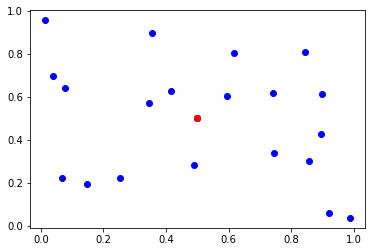

In [19]:
plt.plot(env[0][:,0],env[0][:,1],'bo')
plt.plot(env[0][0,0],env[0][0,1],'ro')

0 15.120319890905549


15.120319890905549

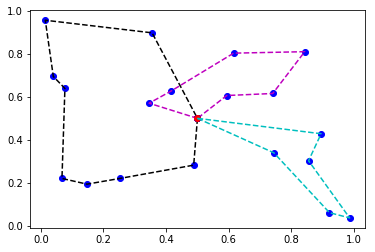

In [38]:
m , n = 1000 ,0
for i in range(20):
    if m > results_0[0][i][1]:
        m, n = i , results_0[0][i][1]
        print(m ,n)
show_graph(results_0[0][m][2])
results_0[0][m][1]

# Map=2

In [21]:
%%time
j = range(20)
n_cores = multiprocessing.cpu_count()
results_1 = []
results_1.append(Parallel(n_jobs=n_cores)(delayed(multi_bee)(num_cities, env[1], num_bees, size, max_epochs,i) for i in j))

Wall time: 11min 7s


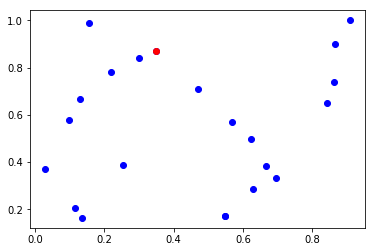

In [22]:
plt.plot(env[1][:,0],env[1][:,1],'bo')
plt.plot(env[1][0,0],env[1][0,1],'ro')

0 16.721491890578974


16.721491890578974

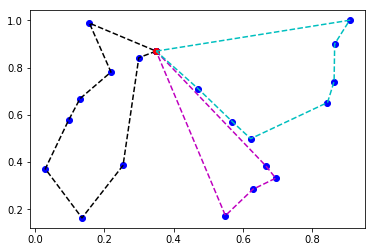

In [24]:
m , n = 1000 ,0
for i in range(20):
    if m > results_1[0][i][1]:
        m, n = i , results_1[0][i][1]
        print(m ,n)
show_graph(results_1[0][m][2])
results_1[0][m][1]

# Map=3

In [35]:
%%time
j = range(20)
results_2 = []
results_2.append(Parallel(n_jobs=-1)(delayed(multi_bee)(num_cities, env[2], num_bees, size, max_epochs,i) for i in j))

Wall time: 11min 32s


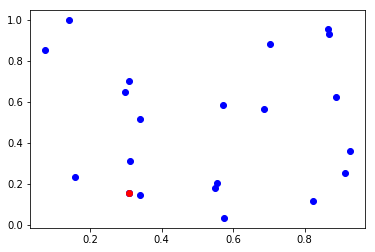

In [36]:
plt.plot(env[2][:,0],env[2][:,1],'bo')
plt.plot(env[2][0,0],env[2][0,1],'ro')

0 26.619717465632895


26.619717465632895

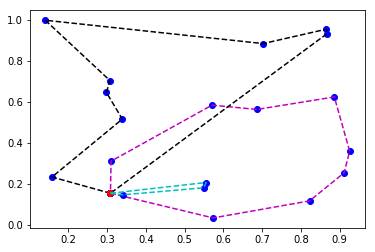

In [37]:
m , n = 1000 ,0
for i in range(20):
    if m > results_2[0][i][1]:
        m, n = i , results_2[0][i][1]
        print(m ,n)
show_graph(results_2[0][m][2])
results_2[0][m][1]

# Map=4

In [28]:
%%time
j = range(20)
results_3 = []
results_3.append(Parallel(n_jobs=-1)(delayed(multi_bee)(num_cities, env[3], num_bees, size, max_epochs,i) for i in j))

Wall time: 12min 17s


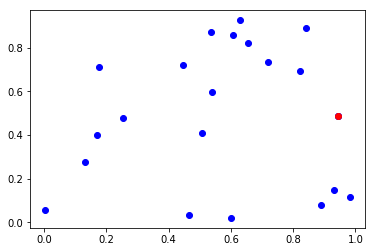

In [29]:
plt.plot(env[3][:,0],env[3][:,1],'bo')
plt.plot(env[3][0,0],env[3][0,1],'ro')

0 26.127892517656115


26.127892517656115

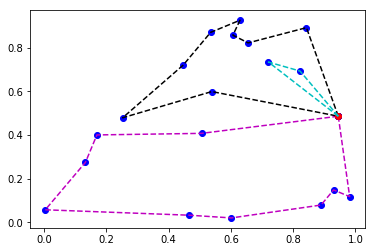

In [31]:
m , n = 1000 ,0
for i in range(20):
    if m > results_3[0][i][1]:
        m, n = i , results_3[0][i][1]
        print(m ,n)
show_graph(results_3[0][m][2])
results_3[0][m][1]

# Map=5

In [32]:
%%time
j = range(20)
results_4 = []
results_4.append(Parallel(n_jobs=-1)(delayed(multi_bee)(num_cities, env[4], num_bees, size, max_epochs,i) for i in j))

Wall time: 11min 40s


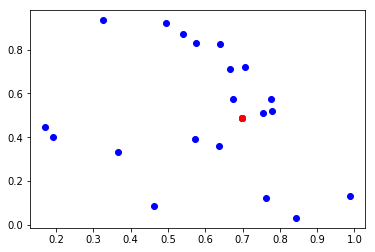

In [33]:
plt.plot(env[4][:,0],env[4][:,1],'bo')
plt.plot(env[4][0,0],env[4][0,1],'ro')

0 7.352277592454624


7.352277592454624

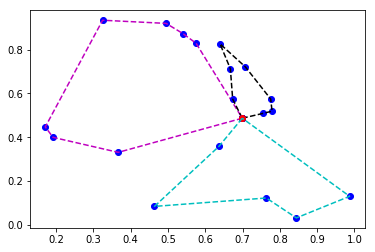

In [34]:
m , n = 1000 ,0
for i in range(20):
    if m > results_4[0][i][1]:
        m, n = i , results_4[0][i][1]
        print(m ,n)
show_graph(results_4[0][m][2])
results_4[0][m][1]